# 1. 数据导入

In [1]:
import pandas as pd
filepath1="train.csv"
filepath2="test.csv"
data_train = pd.read_csv(filepath1)
data_test = pd.read_csv(filepath2)

# 2. 类型转变

In [2]:
data_train.loc[data_train[data_train.is_married == 'married'].index.tolist(),'is_married'] = 0
data_train.loc[data_train[data_train.is_married == 'single'].index.tolist(),'is_married'] = 1
data_train.loc[data_train[data_train.house_ownership == 'norent_noown'].index.tolist(),'house_ownership'] = 0
data_train.loc[data_train[data_train.house_ownership == 'owned'].index.tolist(),'house_ownership'] = 1
data_train.loc[data_train[data_train.house_ownership == 'rented'].index.tolist(),'house_ownership'] = 2
data_train.loc[data_train[data_train.car_ownership == 'no'].index.tolist(),'car_ownership'] = 0
data_train.loc[data_train[data_train.car_ownership == 'yes'].index.tolist(),'car_ownership'] = 1

data_test.loc[data_test[data_test.is_married == 'married'].index.tolist(),'is_married'] = 0
data_test.loc[data_test[data_test.is_married == 'single'].index.tolist(),'is_married'] = 1
data_test.loc[data_test[data_test.house_ownership == 'norent_noown'].index.tolist(),'house_ownership'] = 0
data_test.loc[data_test[data_test.house_ownership == 'owned'].index.tolist(),'house_ownership'] = 1
data_test.loc[data_test[data_test.house_ownership == 'rented'].index.tolist(),'house_ownership'] = 2
data_test.loc[data_test[data_test.car_ownership == 'no'].index.tolist(),'car_ownership'] = 0
data_test.loc[data_test[data_test.car_ownership == 'yes'].index.tolist(),'car_ownership'] = 1


In [3]:
a = ['income','age','experience_years','is_married','city','region','current_job_years',
     'current_house_years','house_ownership','car_ownership','profession']
X_train = data_train[a]
y_train = data_train['label'].astype(int)
X_test = data_test[a]
y_test = data_test['label'].astype(int)

# 3. Catboost模型

In [4]:
from sklearn.model_selection import StratifiedKFold
cat_params = {'learning_rate': 0.1, 
              'depth': 9, 
              'l2_leaf_reg': 10, 
              'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter', 
              'od_wait': 50,  
              'allow_writing_files': False}
folds = StratifiedKFold(n_splits=5, shuffle=True)

In [5]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn import metrics
n_splits = 5
num_classes = 2
verbose = 1
splits = folds.split(X_train, y_train) 
columns = X_train.columns
prediction = np.zeros(shape=(len(X_test), num_classes))
valid_auc_scores = []
for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1}')
        
        X_train_train, X_valid = X_train[columns].iloc[train_index], X_train[columns].iloc[valid_index]
        y_train_train, y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        model = CatBoostClassifier(iterations=20000, 
                                   eval_metric='Logloss',
                                   **cat_params,
                                   loss_function='Logloss')
        model.fit(X_train_train, y_train_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                  verbose=False)

        y_pred_valid = model.predict_proba(X_valid)
        y_pred = model.predict_proba(X_test)

        valid_auc_scores.append(
            metrics.roc_auc_score(y_valid, y_pred_valid[:,1]))
        print(valid_auc_scores)
        prediction += y_pred
prediction /= n_splits
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(valid_auc_scores), np.std(valid_auc_scores)))

Fold 1
[0.9224975053919032]
Fold 2
[0.9224975053919032, 0.913701103783289]
Fold 3
[0.9224975053919032, 0.913701103783289, 0.9188366497992926]
Fold 4
[0.9224975053919032, 0.913701103783289, 0.9188366497992926, 0.924676226236075]
Fold 5
[0.9224975053919032, 0.913701103783289, 0.9188366497992926, 0.924676226236075, 0.9216918398255385]
CV mean score: 0.9203, std: 0.0038.


In [7]:
df = pd.DataFrame(data=prediction[:, 1], 
                  columns=['prediction'])
df[['prediction']].to_csv('cat.csv', index=None)

<BarContainer object of 11 artists>

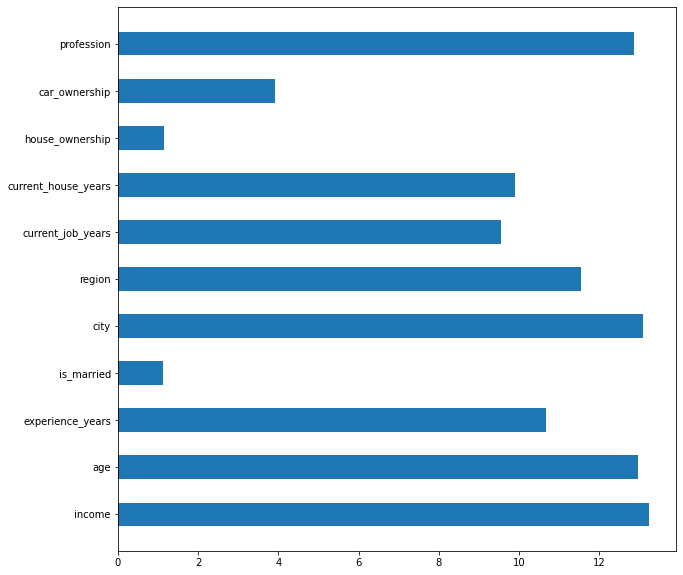

In [8]:
import matplotlib.pyplot as plt 
fea_ = model.feature_importances_
fea_name = model.feature_names_
plt.figure(figsize=(10, 10))
plt.barh(fea_name,fea_,height =0.5)